# Ray Tracing in One Weekend

[Ray Tracing in One Weekend](https://raytracing.github.io/books/RayTracingInOneWeekend.html) in a Julia Notebook.

## Vec3

In [1]:
struct Vec3
    x::Float64
    y::Float64
    z::Float64
end

In [2]:
Base.:+(u::Vec3, v::Vec3) = Vec3(u.x + v.x, u.y + v.y, u.z + v.z)

In [3]:
Base.:-(v::Vec3) = Vec3(-v.x, -v.y, -v.z)
Base.:-(u::Vec3, v::Vec3) = Vec3(u.x - v.x, u.y - v.y, u.z - v.z)

In [4]:
Base.:*(u::Vec3, v::Vec3) = Vec3(u.x * v.x, u.y * v.y, u.z * v.z)
Base.:*(v::Vec3, t::Number) = Vec3(v.x * t, v.y * t, v.z * t)
Base.:*(t::Number, v::Vec3) = v * t

In [5]:
Base.:/(v::Vec3, t::Number) = Vec3(v.x / t, v.y / t, v.z / t)

In [6]:
length_squared(v::Vec3) = v.x * v.x + v.y * v.y + v.z * v.z

length_squared (generic function with 1 method)

In [7]:
# length(collection) is for number of elements
length_vector(v::Vec3) = sqrt(length_squared(v))

length_vector (generic function with 1 method)

In [8]:
dot(u::Vec3, v::Vec3) = u.x * v.x + u.y * v.y + u.z * v.z

dot (generic function with 1 method)

In [9]:
cross(u::Vec3, v::Vec3) = Vec3(
    u.y * v.z - u.z * v.y,
    u.z * v.x - u.x * v.z,
    u.x * v.y - u.y * v.x
)

cross (generic function with 1 method)

In [10]:
unit_vector(v::Vec3) = v / length_vector(v)

unit_vector (generic function with 1 method)

In [11]:
function random_in_unit_sphere()
    while true
        p = Vec3(rand(-1:eps():1, 3)...)
        if length_squared(p) < 1
            return p
        end
    end
 end

random_in_unit_sphere (generic function with 1 method)

In [12]:
function random_unit_vector()
    a = rand(0:eps():2pi)
    z = rand(-1:eps():1)
    r = sqrt(1 - z * z)
    Vec3(r * cos(a), r * sin(a), z)
end

random_unit_vector (generic function with 1 method)

In [13]:
function random_in_hemisphere(normal::Vec3)
    in_unit_sphere = random_in_unit_sphere()
    if dot(in_unit_sphere, normal) > 0
        in_unit_sphere
    else
        -in_unit_sphere
    end
end

random_in_hemisphere (generic function with 1 method)

## Ray

In [14]:
struct Ray
    origin::Vec3
    direction::Vec3
end

In [15]:
at(ray::Ray, t::Number) = ray.origin + t * ray.direction

at (generic function with 1 method)

## Hittable, HitRecord and HittableList

In [16]:
abstract type Hittable end

In [17]:
struct HitRecord
    p::Vec3
    normal::Vec3
    t::Float64
    front_face::Bool
    
    function HitRecord(p::Vec3, t::Number, r::Ray, outward_normal::Vec3)
        front_face = dot(r.direction, outward_normal) < 0
        normal = front_face ? outward_normal : -outward_normal
        new(p, normal, t, front_face)
    end
 end

In [18]:
struct HittableList <: Hittable
    objects::Vector{Hittable}
end

In [19]:
function hit(
        hl::HittableList,
        r::Ray,
        t_min::Number,
        t_max::Number,
        )::Union{HitRecord,Nothing}
    closest_so_far = t_max
    
    hr::Union{HitRecord,Nothing} = nothing
    
    for obj in hl.objects
        temp_hr = hit(obj, r, t_min, closest_so_far)
        if temp_hr != nothing
            closest_so_far = temp_hr.t
            hr = temp_hr
        end
    end
    
    hr
 end

hit (generic function with 1 method)

## Sphere

In [20]:
struct Sphere <: Hittable
    center::Vec3
    radius::Float64
end

In [21]:
function hit(
        sphere::Sphere,
        r::Ray,
        t_min::Number,
        t_max::Number,
        )::Union{HitRecord,Nothing}
    
    oc = r.origin - sphere.center
    a = length_squared(r.direction)
    half_b = dot(oc, r.direction)
    c = length_squared(oc) - sphere.radius * sphere.radius
    discriminant = half_b * half_b - a * c

    if discriminant > 0
        root = sqrt(discriminant)
        temp = (-half_b - root) / a
        if t_min < temp < t_max
            p = at(r, temp)
            outward_normal = (p - sphere.center) / sphere.radius
            HitRecord(p, temp, r, outward_normal)
        else
            temp = (-half_b + root) / a
            if t_min < temp < t_max
                p = at(r, temp)
                outward_normal = (p - sphere.center) / sphere.radius
                HitRecord(p, temp, r, outward_normal)
            end
        end
    end
end

hit (generic function with 2 methods)

## Camera

In [22]:
struct Camera
    origin::Vec3
    lower_left_corner::Vec3
    horizontal::Vec3
    vertical::Vec3
    
    Camera() = new(Vec3(0, 0, 0), Vec3(-2, -1, -1), Vec3(4, 0, 0), Vec3(0, 2, 0))
end

In [23]:
get_ray(c::Camera, u::Number, v::Number)::Ray = Ray(
    c.origin,
    c.lower_left_corner + u * c.horizontal + v * c.vertical - c.origin,
)

get_ray (generic function with 1 method)

## Image

In [24]:
using Images

In [25]:
const aspect_ratio = 16 / 9
const image_width = 384
const image_height = Int(image_width ÷ aspect_ratio)
const samples_per_pixel = 100
const max_depth = 50;

In [26]:
const world = HittableList([
        Sphere(Vec3(0, 0, -1), 0.5),
        Sphere(Vec3(0, -100.5, -1), 100),
        ])

HittableList(Hittable[Sphere(Vec3(0.0, 0.0, -1.0), 0.5), Sphere(Vec3(0.0, -100.5, -1.0), 100.0)])

In [27]:
const cam = Camera()

Camera(Vec3(0.0, 0.0, 0.0), Vec3(-2.0, -1.0, -1.0), Vec3(4.0, 0.0, 0.0), Vec3(0.0, 2.0, 0.0))

In [28]:
function ray_color(r::Ray, depth::Int)
    if depth <= 0
        return Vec3(0, 0, 0)
    end
    
    hr = hit(world, r, 0.001, Inf)
    
    if hr != nothing
        target = hr.p + random_in_hemisphere(hr.normal)
        0.5 * ray_color(Ray(hr.p, target - hr.p), depth - 1)
    else
        unit_direction = unit_vector(r.direction)
        t = 0.5 * (unit_direction.y + 1)
        (1 - t) * Vec3(1, 1, 1) + t * Vec3(0.5, 0.7, 1)
    end
end

ray_color (generic function with 1 method)

In [29]:
function color(i::Int, j::Int)
    c = Vec3(0, 0, 0)
    for _ = 1:samples_per_pixel
        u = (i + rand()) / image_width
        v = (j + rand()) / image_height
        r = get_ray(cam, u, v)
        c += ray_color(r, max_depth)
    end
    c /= samples_per_pixel
    RGB(sqrt(c.x), sqrt(c.y), sqrt(c.z))
end

color (generic function with 1 method)

In [30]:
function render()
    [color(i, j) for j in image_height:-1:1, i in 1:image_width]
end

render (generic function with 1 method)

  3.789948 seconds (57.21 M allocations: 2.048 GiB, 7.23% gc time)


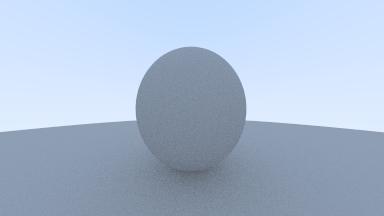

In [32]:
@time render()